# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [22]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [23]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [24]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [25]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [26]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753589311341033


### Look at the logistc regression coefficients

In [13]:
coef = clf.named_steps.get("logisticregression").coef_

In [14]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [15]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [16]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'fuck': 32.7837917280138,
 'fucking': 27.82425052783078,
 'idiot': 20.15266937256496,
 'shit': 20.013563243286278,
 'bitch': 18.475908925024964,
 'bullshit': 18.10295490046663,
 'ass': 18.077966939946386,
 'asshole': 17.57561292196972,
 'stupid': 16.622723488339,
 'suck': 16.11790605183115,
 'faggot': 15.378837213619931,
 'cunt': 14.868528007269816,
 'fucked': 13.81268406440718,
 'bastard': 13.281050718084172,
 'sucks': 13.276981732229888,
 'idiots': 13.246334105799505,
 'dick': 13.15745751086574,
 'moron': 12.716570056508065,
 'crap': 12.421849116680283,
 'idiotic': 12.05640679677976,
 'fucker': 11.918809872032933,
 'penis': 11.841626404913812,
 'cock': 11.75222203927742,
 'motherfucker': 11.679984445953181,
 'nigger': 11.417909656954315,
 'dumbass': 11.406342587802497,
 'jerk': 11.21120568622119,
 'pussy': 11.119175729917208,
 'dickhead': 10.554774339384167,
 'pathetic': 10.553991439145115,
 'faggots': 10.48665264384712,
 'assholes': 10.465908992082616,
 'fuckin': 10.34301322437423,

### probe the model a bit

In [17]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.95867571 0.04132429]]


In [18]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.95762929 0.04237071]]


In [19]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.96072211 0.03927789]]


In [20]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.66363873 0.33636127]]


## Test Counterfactual based bias detection

In [73]:
from biaslyze.bias_detectors import LimeKeywordBiasDetector, CounterfactualBiasDetector

In [74]:
bias_detector = CounterfactualBiasDetector()

In [75]:
counterfactual_detection_results = bias_detector.process(texts=df.comment_text.sample(10000), predict_func=clf.predict_proba)

2023-05-12 11:31:48.318 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4234.83it/s]
2023-05-12 11:31:50.684 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8991 texts with protected concepts.
2023-05-12 11:31:50.686 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:67 - Processing concept nationality...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8991/8991 [03:39<00:00, 40.97it/s]
2023-05-12 11:35:30.139 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:_extract_concept_samples:112 - Extracted 2148 sample texts for concept national

In [76]:
counterfactual_detection_results.report()

Concept: nationality		Max-Mean Counterfactual Score: 0.022937883454420268
Concept: ethnicity		Max-Mean Counterfactual Score: 0.024292513628591625
Concept: religion		Max-Mean Counterfactual Score: 0.025372870156482562
Concept: gender		Max-Mean Counterfactual Score: 0.0696851639618837
Concept: gendered words		Max-Mean Counterfactual Score: 0.0295739899365199


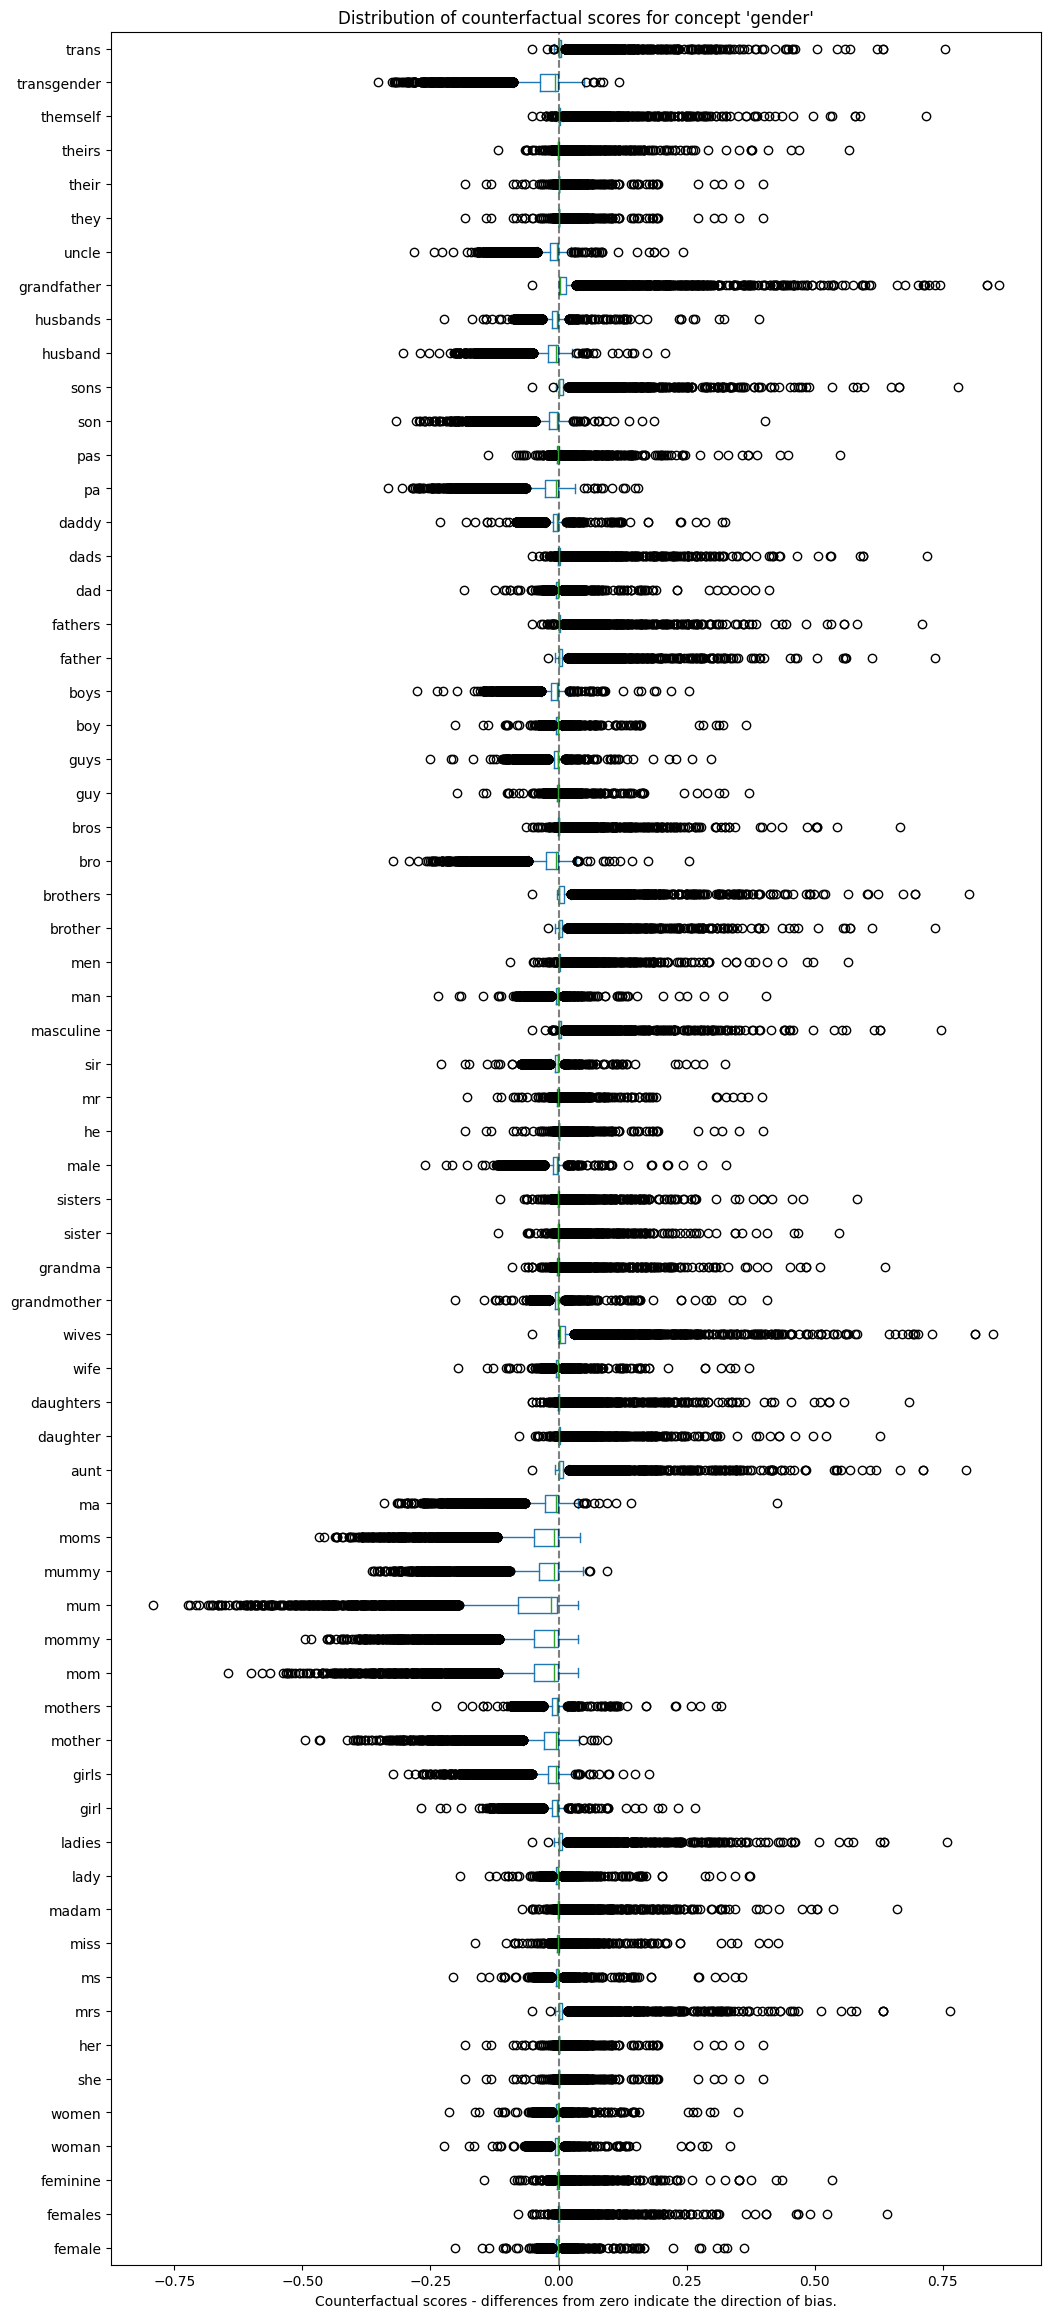

In [77]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="gender")

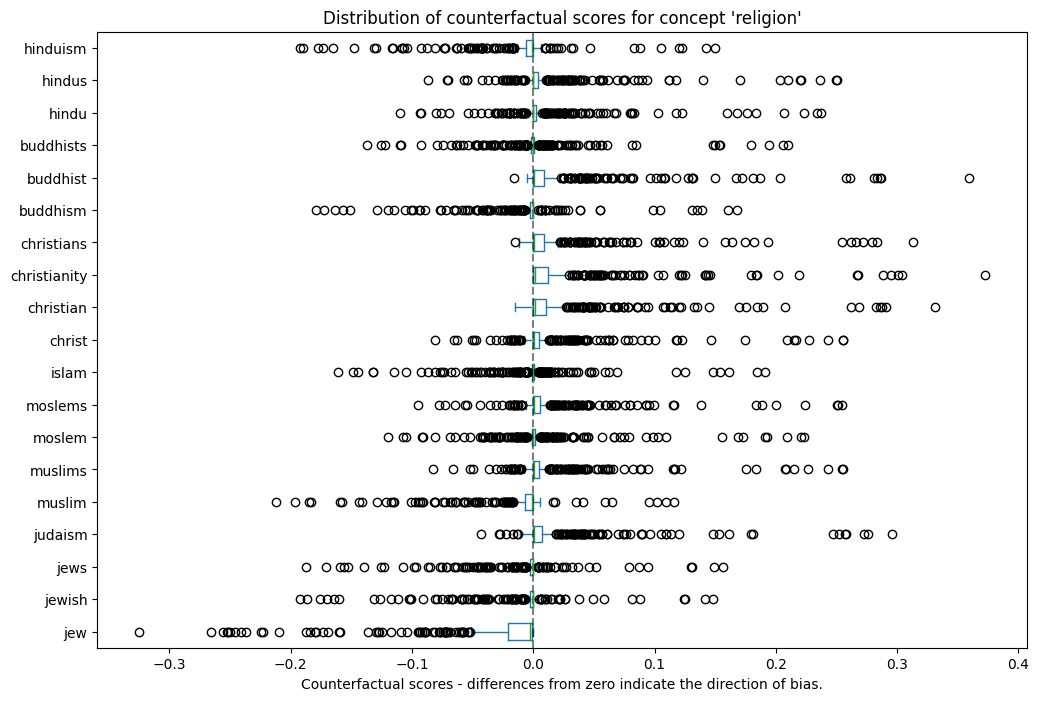

In [78]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion")

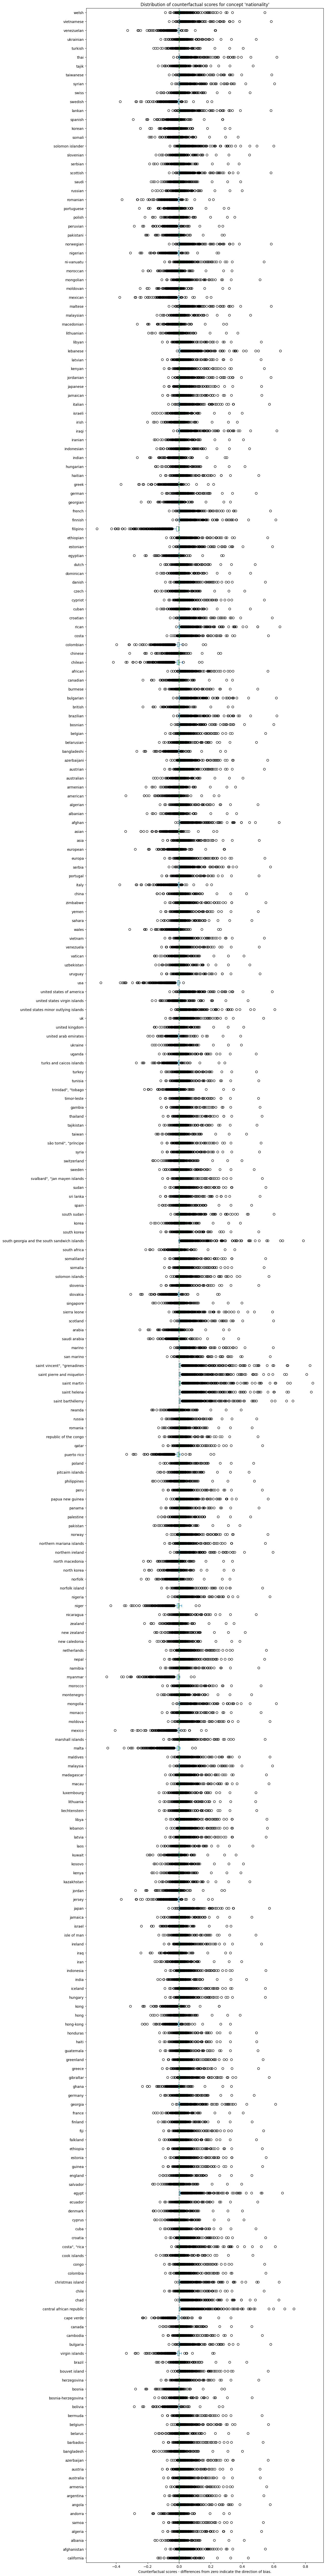

In [79]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="nationality")

## Test LIME based bias detection with keywords

In [252]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [253]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=1000),
    n_top_keywords=30,
    use_tokenizer=True
)

In [23]:
test_texts = df.comment_text.sample(100)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-11 11:02:34.824 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 100 texts...
  0%|                                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.92it/s]
2023-05-11 11:02:35.636 | INFO     | biaslyze.co

In [24]:
detection_res.summary()

Detected 27 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 27), ('nationality', 2)]
    Based on keywords: [('he', 7), ('his', 5), ('they', 4), ('man', 3), ('them', 3), ('her', 2), ('guys', 2), ('himself', 1), ('ecuador', 1), ('their', 1), ('she', 1), ('guy', 1), ('woman', 1), ('boy', 1), ('him', 1), ('male', 1), ('girl', 1), ('italy', 1), ('german', 1), ('father', 1)].


In [25]:
detection_res.details(group_by_concept=True)

Concept: gender
[{'reason': ['himself'],
  'text': ", even a huge crack database.  Thus it's clear that Alkivar wants "
          'all the vanity for himself.'},
 {'reason': ['ecuador', 'they'],
  'text': '"\n'
          '\n'
          ' Hey \n'
          '\n'
          'Thank you for trying; however, many of the articles you have '
          'created, such as the one on the Republic of Ecuador, and the one  '
          'on ""Our Neighbors North and South""... they aren\'t really '
          '""articles"", per se. I\'d like to suggest that you read several '
          'more articles first, so as to get a better feel for what articles '
          'should be about.\n'
          '\n'
          'Sorry.  "'},
 {'reason': ['his'],
  'text': 'What I envision is a separate section for his horse activities, '
          'which could certainly lead off with the tale you mention.'},
 {'reason': ['man', 'he'],
  'text': 'Note how in the 1980 movie Flash Gordon, Flash looks a whole lot '
          '

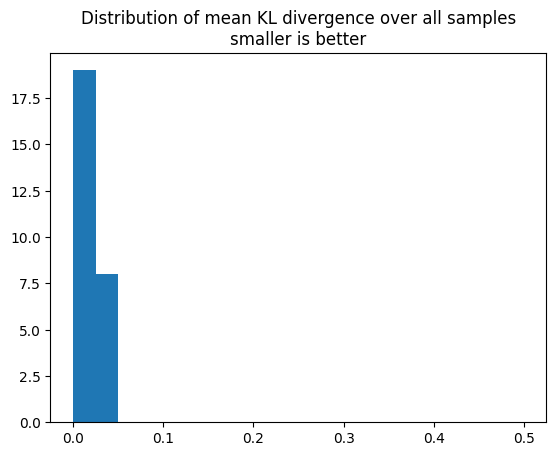

In [28]:
plt.hist([sample.metrics.get("mean_KL_divergence") for sample in detection_res.biased_samples], bins=20, range=[0,0.5])
plt.title("Distribution of mean KL divergence over all samples\nsmaller is better");

In [29]:
test_df = df.iloc[test_texts.index]

In [30]:
test_df[test_df.target].reset_index().comment_text[4]

'the category was unnecesary, as explained in my edit summary. Your threats are disgrace to wikipedia.'

In [31]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [32]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [ ]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [ ]:
topic_model.topic_labels_

In [ ]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [ ]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [ ]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [ ]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## Experiment with global importance of concept-keywords

In [9]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
key_detect = KeywordConceptDetector()

In [12]:
detected_texts = key_detect.detect(texts=df.comment_text)

2023-05-11 18:56:25.689 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 159571 texts...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159571/159571 [00:35<00:00, 4545.94it/s]
2023-05-11 18:57:00.795 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 143603 texts with protected concepts.


In [13]:
len(detected_texts)

143603

In [14]:
detected_texts[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [15]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
316it [00:04, 68.45it/s] 


KeyboardInterrupt: 

In [ ]:
score_df.describe()

In [ ]:
np.abs(score_df.mean()).max()

In [ ]:
plot_scores(dataf=score_df, concept="gender")

In [ ]:
bias_keyword = "father"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [ ]:
bias_keyword = "mom"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [ ]:
religion_score_df = calculate_all_scores(texts=detected_texts, concept="religion", clf=clf, n_samples=10000)

In [ ]:
plot_scores(religion_score_df, concept="religion")

In [ ]:
np.abs(religion_score_df.mean()).max()

## Try some bubble plots with counterfactual sample score

In [53]:
from biaslyze.counterfactual_score import calculate_counterfactual_sample_score, extract_concept_samples

In [130]:
samples = extract_concept_samples(texts=detected_texts, concept="religion", N=10000)

10000it [01:01, 162.73it/s]

Extracted 324 sample texts for concept religion


In [190]:
cs_scores = []
cs_score_diffs = []
for sample in tqdm(samples):
    original_scores, predicted_scores = calculate_counterfactual_sample_score(sample, concept="religion", clf=clf)
    score_diffs = np.array(original_scores) - np.array(predicted_scores)
    cs_score_diffs.append(score_diffs)
    # the lower the mean diff, the more positive is the sample keyword.
    # multiply by -1 to make greater more positive.
    cs_scores.append(-1 * score_diffs.mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:03<00:00, 95.88it/s]


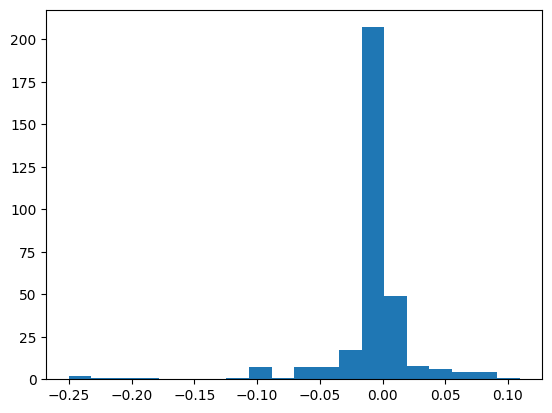

In [166]:
plt.hist(cs_scores, bins=20);

In [167]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [168]:
# Prepare embeddings
docs = [sample.text for sample in samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
#topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)
topic_model = BERTopic(vectorizer_model=vectorizer_model).fit(docs, embeddings)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [169]:
# topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [171]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords"), ("Counterfactual score", "@counterfactual_sample_score")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    #bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    #concept2int = list(set(bias_concept))
    #num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = np.array(cs_scores)
    
    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in samples],
        keywords=[sample.keyword for sample in samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in (bias_intensity >= 0).astype(int)],
        bias_intensity=500 * np.abs(bias_intensity),
        counterfactual_sample_score=np.round(cs_scores, 4),
        #bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        #legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=df.bias_intensity.max(), step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)

    doc.add_root(column(threshold, p, width=800))

    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

In [196]:
from collections import defaultdict

counterfactual_plot_dict = defaultdict(list)

for sample, score in zip(samples, cs_score_diffs):
    counterfactual_plot_dict[sample.keyword].extend(score.tolist())

In [197]:
counterfactual_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in counterfactual_plot_dict.items() ]))

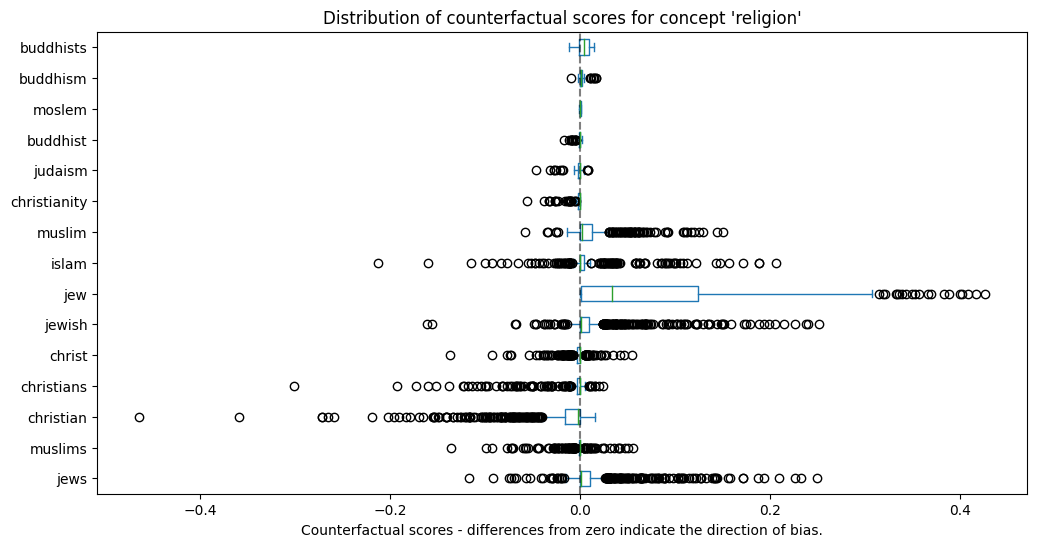

In [198]:
plot_scores(counterfactual_df, concept="religion")

## Test the stupid hatespeech detection model

https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain

https://github.com/hate-alert/HateXplain

In [ ]:
from transformers import pipeline
from typing import List

In [ ]:
class HateSpeechClf:
    
    def __init__(self):
        self._classifier = pipeline(model="Hate-speech-CNERG/bert-base-uncased-hatexplain")
        
    def predict_proba(self, texts: List[str]):
        res = self._classifier(texts, top_k=None, truncation=True, batch_size=4)
        return np.array([np.array([d[0]["score"], d[1]["score"] + d[2]["score"]]) for d in res])

In [ ]:
hate_clf = HateSpeechClf()

In [ ]:
hate_score_df = calculate_all_scores(texts=detected_texts, concept="religion", clf=hate_clf, n_samples=5000)

In [ ]:
plot_scores(hate_score_df, concept="religion")
plt.savefig("hatespeech_dl_scores_religion.png")